In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/fastai/fastai
!pip install -e "fastai[dev]"

In [3]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/programmers/data/train.zip' -d '/content'
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/programmers/data/test.zip' -d '/content'

# 프로그래머스 과제관 - 미술 작품 분류

## 데이터 설명

```
- 데이터 셋은 art painting으로 구성되어 있으며 7개의 카테고리로 구분
- 7개의 카테고리로는 classes에서 정의한 dog, elephant, giraffe, guitar, horse, house, person를 포함
- 하나의 이미지의 사이즈는 [3(Channel) * 227(Width) * 227(Height)]이며 각 카테고리 별 예시 이미지는 아래에서 확인
- 훈련 데이터 1698장, 테스트 데이터 350장
```

## 라이브러리 임포트 및 버전확인

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

import platform
import sys
import os
import sklearn 
import cv2
from glob import glob
# from shutil import copyfile
from sklearn.model_selection import StratifiedKFold

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

import torch
from torchvision import models
from torch.utils.data import Dataset
from torchvision.models.efficientnet import efficientnet_b0, efficientnet_b1
from sklearn.metrics import f1_score 
from tqdm import tqdm
from fastai.vision.all import *
# from fastai.tabular import *

class config:
    seed = 42
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    lr = 3e-3
    epochs = 100
    batch_size = 16
    # num_workers = 4
    patience = 5
    min_delta = 1e-3
    dropout= 0.1
    optimizer = 'Adam'
    train_5_folds = True
    tta = True
    scheduler = ''
    
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

Setup complete. Using torch 1.10.0+cu111 (Tesla T4)
- os: Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
- pandas: 1.3.5
- numpy: 1.21.5
- sklearn: 1.0.2
- pytorch: 1.10.0+cu111
- opencv: 4.1.2


시드고정

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(config.seed)

# train & inference

# 모델 구현 과정

## Data Exploration
* dataloader에 이미지 경로와 라벨 정보를 넣어주기 위해 glob 모듈을 이용하여 모든 경로를 가져옴. 
* 가져온 경로를 이용하여 경로와 라벨을 데이터 프레임으로 만듦.
* 5fold를 하기위해 fold 열 추가

In [3]:
train_path = '/content/train/'
test_path = 'test/0'

train_jpg = glob.glob(train_path+'*/*.jpg')
df_train = pd.DataFrame()
df_train['dir'] = train_jpg
df_train['labels'] = df_train.dir.apply(lambda x: x.split('/')[3])
df_train['fold']=0
df_train

dir labels  fold
0       /content/train/dog/pic_194.jpg    dog     0
1       /content/train/dog/pic_112.jpg    dog     0
2       /content/train/dog/pic_051.jpg    dog     0
3       /content/train/dog/pic_064.jpg    dog     0
4       /content/train/dog/pic_284.jpg    dog     0
...                                ...    ...   ...
1693  /content/train/horse/pic_150.jpg  horse     0
1694  /content/train/horse/pic_096.jpg  horse     0
1695  /content/train/horse/pic_134.jpg  horse     0
1696  /content/train/horse/pic_126.jpg  horse     0
1697  /content/train/horse/pic_093.jpg  horse     0

[1698 rows x 3 columns]

person      399
dog         329
house       245
giraffe     235
elephant    205
horse       151
guitar      134
Name: labels, dtype: int64


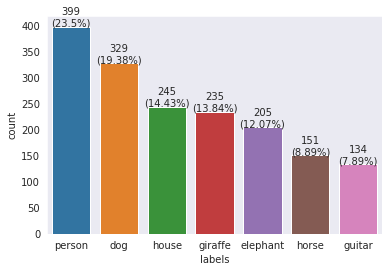

In [21]:
print(df_train.labels.value_counts())
object_cnt = df_train["labels"].value_counts()
sns.countplot(df_train["labels"], order=object_cnt.index)
for x,y,z in zip(range(len(object_cnt)), object_cnt.values, object_cnt.values/object_cnt.sum()*100):
    plt.annotate(f"{y}\n({round(z,2)}%)", xy=(x,y), textcoords="data", ha="center")

가장 많은 클래스 수의 가장 적은 클래스 수의 약 3배

## 이미지 데이터 확인

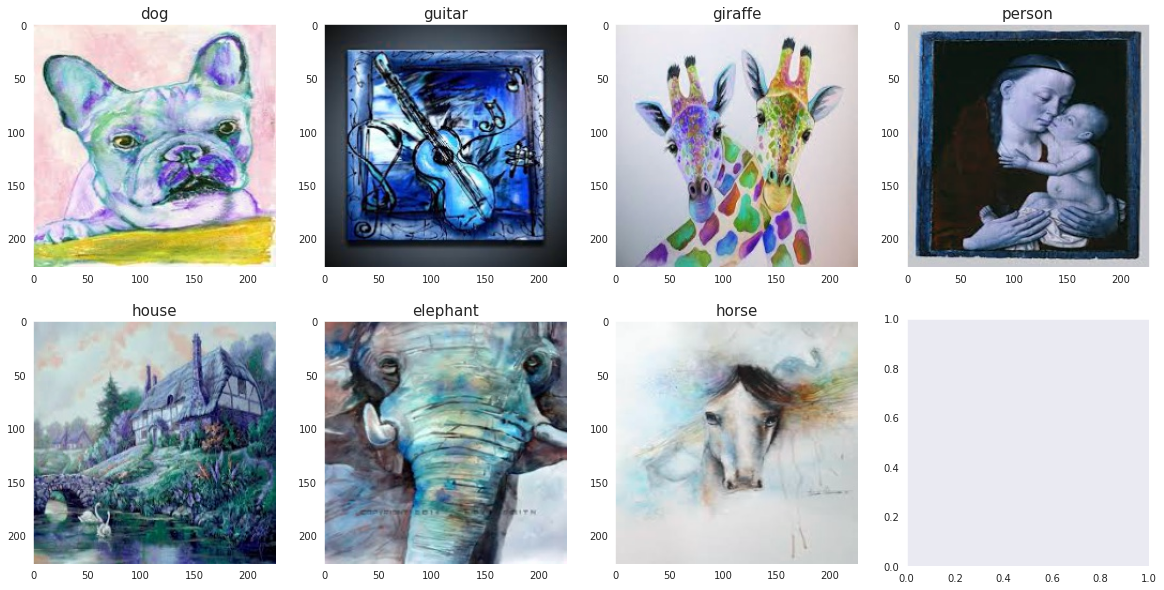

In [22]:
f, ax = plt.subplots(2,4, figsize=(20,10))

for i, cls in enumerate(df_train.labels.unique()):
    idx = df_train[df_train.labels==cls].index[0]
    sample = cv2.imread(df_train.dir[idx])
    ax[i//4][i%4].imshow(sample)
    ax[i//4][i%4].set_title(cls, fontsize=15)
plt.show()

## 구현 계획
- 1,698장의 적은 학습데이터셋: aug_transforms을 이용하여 데이터 증강
  - pad_mode는 zero, reflection, border가 있는데 border옵션이 훈련 데이터와 가장 비슷한 효과를 주는 듯 하여 선택함
  - flip_vert=False vertical flip은 사용하지 않음
  - 그림 특성상 색상이 다양하므로 xtra_tfms에 Saturation, Hue 변형 추가
  - 데이터 셋의 mean, std를 이용하여 정규화 수행
  - (참고)aug_transforms 종류 : https://docs.fast.ai/vision.augment.html
  - RandomErasing :일반화 성능을 높이고 robust한 모델을 위해 
- Normalize
  - 훈련 데이터의 mean, std를 이용하여 정규화

- 5-fold cross validation
  - StratifiedKFold로 나눈 fold 번호를 이용하여 매 fold에 해당하는 validation data의 인덱스를 리턴하는 splitter 함수를 정의하여 indexSplitter에 입력으로 넣어줌.
  - IndexSplitter는 valid index list를 받아서 train, valid data로 나누어주는 splitter

- inference
  - ensemble
  - TTA(Test Time Augmentation)
  


## StratifiedKFold
- 클래스별 비율을 맞춰 train / validation set split

In [ ]:
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.seed)

for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train.labels)):
    df_train.loc[val_index, 'fold'] = int(n)
df_train['fold'] = df_train['fold'].astype(int)
# df_train.to_csv('train_fold.csv', index=False)
df_train

dir    labels  fold
0       /content/train/guitar/pic_034.jpg    guitar     4
1       /content/train/guitar/pic_012.jpg    guitar     2
2       /content/train/guitar/pic_087.jpg    guitar     3
3       /content/train/guitar/pic_127.jpg    guitar     0
4       /content/train/guitar/pic_073.jpg    guitar     1
...                                   ...       ...   ...
1693  /content/train/elephant/pic_086.jpg  elephant     0
1694  /content/train/elephant/pic_120.jpg  elephant     2
1695  /content/train/elephant/pic_096.jpg  elephant     2
1696  /content/train/elephant/pic_071.jpg  elephant     3
1697  /content/train/elephant/pic_133.jpg  elephant     0

[1698 rows x 3 columns]

## datablock 생성

In [ ]:
def get_x(df): return df['dir']
def get_y(df): return df['labels'].split(' ')
def splitter(df, num_fold:int):
    #train = df.index[df.fold==num_fold].tolist()
    valid = df.index[df['fold']!=num_fold].tolist()
    return valid

def get_dls(df, num_fold, bs:int=32, img_size:int=224):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                                splitter=IndexSplitter(splitter(df,num_fold)),
                                get_x = get_x,
                                get_y = get_y,
                                item_tfms = Resize(img_size), 
                                batch_tfms=[*aug_transforms(size=img_size, max_rotate=15.0, min_scale=0.5, max_zoom=1.2,
                                                            max_lighting=0.2, max_warp=0.2, p_affine=.75, p_lighting=.75,
                                                            pad_mode='border', do_flip=True, flip_vert=False, mult=2,     # mult 변형정도 조정
                                                            xtra_tfms=[Saturation(p=0.1, draw=0.5), Saturation(p=0.1, draw=1.5), 
                                                                       Hue(p=.1,draw=0.75), Hue(p=.1, draw=1.5),
                                                                       Contrast(draw=0.5, p=.1), RandomErasing(p=.2, max_count=2)
                                                                       ],),
                                            Normalize, 
                                          ])
                                                  #, Normalize.from_stats(*imagenet_stats)) # 이미지넷 mean std사용할떄
    return dblock.dataloaders(df, bs=bs) 


## 배치 이미지 확인

In [ ]:
dls = get_dls(df_train, num_fold=0, bs=128, img_size=224)

In [ ]:
x, y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.2479, -0.2829, -0.3388], device='cuda:0'),
 TensorImage([1.0668, 0.9964, 1.0262], device='cuda:0'))

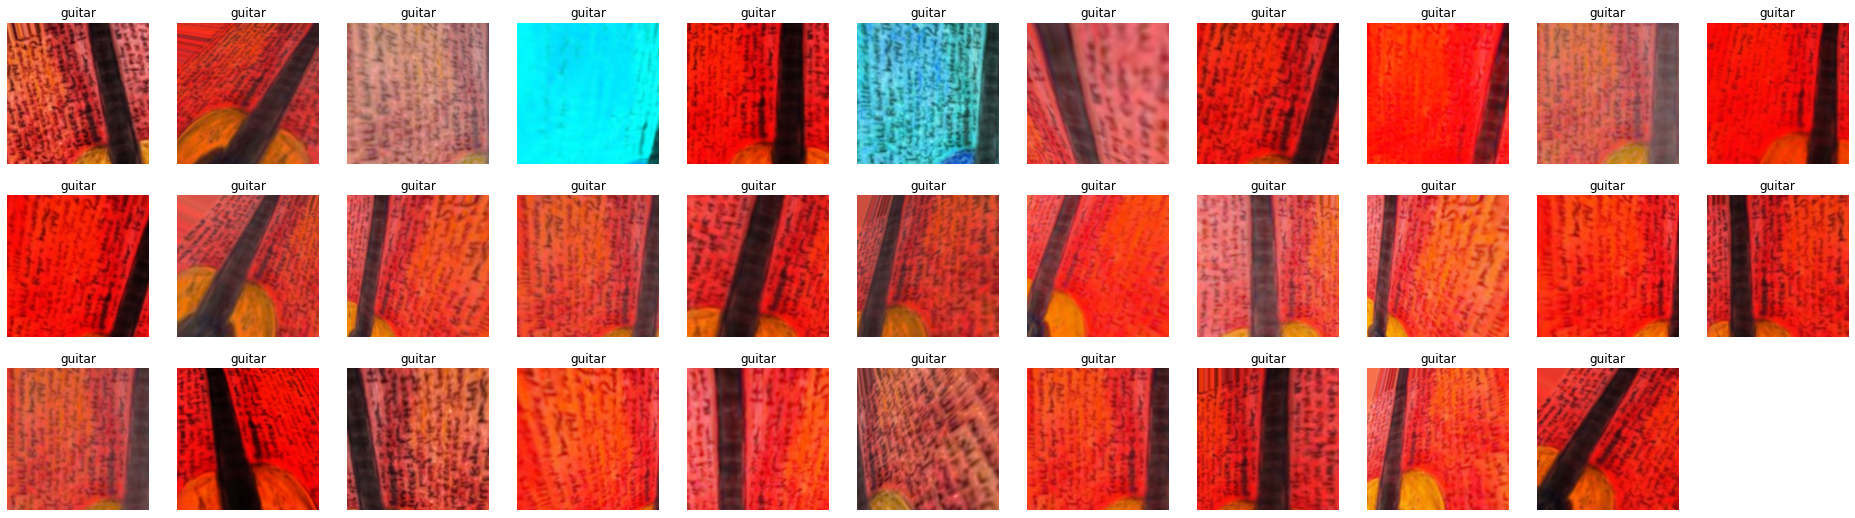

In [ ]:
dls.train.show_batch(max_n=32, nrows=3, unique=True)

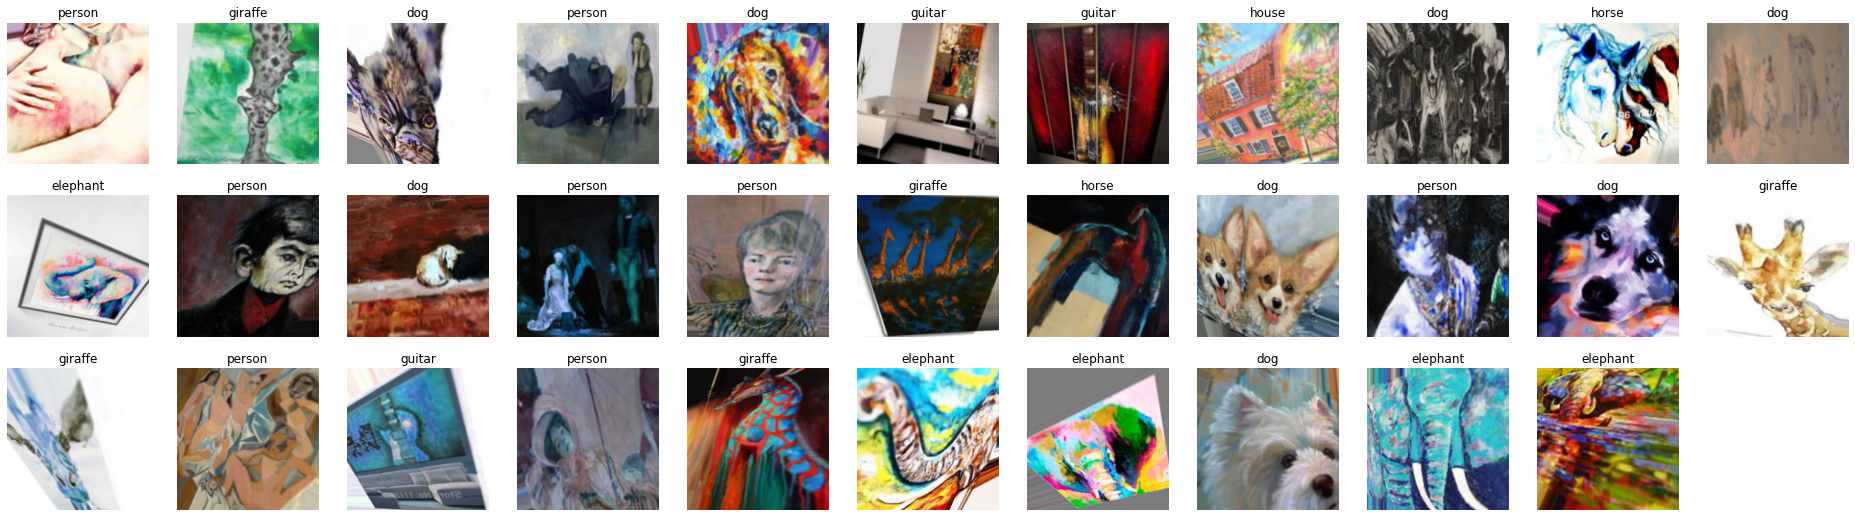

In [ ]:
dls.train.show_batch(max_n= 32, nrows=3)

## 모델 선정 
  - SOTA인 EfficientNet 사용
  - lossfunc
    - 실험을 통해 BCEWithLogitsLossFlat, CrossEntropyLossFlat 중 더 안정적이고 빠르게 학습되는 후자 선택
    - fastAI의 multicategory block을 사용하여 원-핫 인코딩이 되어있기 때문에 Falt loss 사용
  - optimizer = adam

### data imbalance 완화
  - 각 클래스에 max class 수 / class 수로 가중치 설정

### 첫번째 폴드만을 이용하여 사전 테스트
  - 빠른 계산을 위해 fp16 사용

In [ ]:
cls_num = [df_train.labels.value_counts()[cls] for cls in dls.train.vocab]
cls_w = torch.FloatTensor(np.max(cls_num)/cls_num).cuda()
learn = cnn_learner(dls, efficientnet_b0,
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=config.min_delta, patience=config.patience))
learn.crit = CrossEntropyLossFlat(weight=cls_w)

#### learning rate 탐색 : 3e-3으로 결정

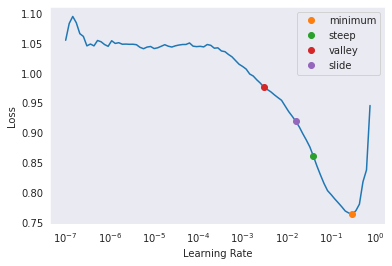

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

#### 최적의 임계점 탐색
- multi class에 추론때도 max confidence를 가진 값을 label로 추론하기 때문에 사실상 필요없는 작업이였음.ㅠ

In [ ]:
learn.to_fp16().fit_one_cycle(config.epochs, 3e-3)

No improvement since epoch 50: early stopping


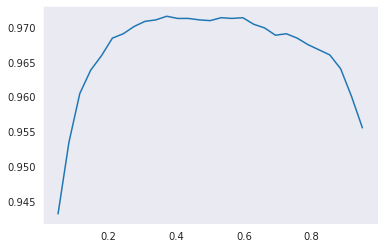

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)
preds, targs = learn.get_preds()
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [ ]:
thresh = 0.39
learn.metrics = partial(accuracy_multi, thresh=thresh)
print(f'thresh={thresh}: {learn.validate()[1]}')

thresh = 0.38
learn.metrics = partial(accuracy_multi, thresh=thresh)
print(f'thresh={thresh}: {learn.validate()[1]}')

thresh = 0.37
learn.metrics = partial(accuracy_multi, thresh=thresh)
print(f'thresh={thresh}: {learn.validate()[1]}')

thresh=0.39: 0.9714916348457336


thresh=0.38: 0.9717022776603699


thresh=0.37: 0.971491813659668


## 최종모델
### 5 fold cross validation

In [ ]:
scores = []
for fold in range(5):
    print(f'{"="*15} {fold+1} / 5 folds {"="*15}')
    dls = get_dls(df_train, num_fold=fold)
    cls_num = [df_train.labels.value_counts()[cls] for cls in dls.train.vocab]
    cls_w = torch.FloatTensor(np.max(cls_num)/cls_num).cuda()
    learn = cnn_learner(dls, efficientnet_b0,
                        metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                        cbs=[SaveModelCallback(fname=f'{fold+1}_fold_best'),
                             EarlyStoppingCallback(monitor='valid_loss', min_delta=config.min_delta, patience=config.patience)])

    learn.crit = CrossEntropyLossFlat(weight=cls_w)
    learn.to_fp16().fit_one_cycle(config.epochs, config.lr)

best_models = []
for fold in range(5):
    learn = cnn_learner(dls, efficientnet_b0,
                        metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                        cbs=[SaveModelCallback(fname=f'{fold+1}_fold_best'),
                            EarlyStoppingCallback(monitor='valid_loss', min_delta=config.min_delta, patience=config.patience)])
    learn.crit = CrossEntropyLossFlat(weight=cls_w)
    best_models.append(learn.load(f'{fold+1}_fold_best'))
    
for i, model in enumerate(best_models):
    loss, acc, f1 = model.validate()
    print(f'[{i+1} fold] accuracy : {acc}')

=============== 1 / 5 folds ===============


Better model found at epoch 0 with valid_loss value: 0.7660020589828491.
Better model found at epoch 1 with valid_loss value: 0.7380068898200989.
Better model found at epoch 2 with valid_loss value: 0.6914020776748657.
Better model found at epoch 3 with valid_loss value: 0.6568723917007446.
Better model found at epoch 4 with valid_loss value: 0.6370059251785278.
Better model found at epoch 5 with valid_loss value: 0.5926602482795715.
Better model found at epoch 6 with valid_loss value: 0.5698228478431702.
Better model found at epoch 7 with valid_loss value: 0.5483425259590149.
Better model found at epoch 8 with valid_loss value: 0.490872859954834.
Better model found at epoch 9 with valid_loss value: 0.4465397596359253.
Better model found at epoch 10 with valid_loss value: 0.4441590905189514.
Better model found at epoch 11 with valid_loss value: 0.3833707571029663.
Better model found at epoch 12 with valid_loss value: 0.31777551770210266.
Better model found at epoch 13 with valid_loss v

Better model found at epoch 0 with valid_loss value: 0.873823344707489.
Better model found at epoch 1 with valid_loss value: 0.7343371510505676.
Better model found at epoch 2 with valid_loss value: 0.6624959111213684.
Better model found at epoch 3 with valid_loss value: 0.6312624216079712.
Better model found at epoch 4 with valid_loss value: 0.6045072078704834.
Better model found at epoch 6 with valid_loss value: 0.5632749199867249.
Better model found at epoch 7 with valid_loss value: 0.4717043936252594.
Better model found at epoch 8 with valid_loss value: 0.4457220435142517.
Better model found at epoch 9 with valid_loss value: 0.44367340207099915.
Better model found at epoch 10 with valid_loss value: 0.3887369930744171.
Better model found at epoch 11 with valid_loss value: 0.37682202458381653.
Better model found at epoch 12 with valid_loss value: 0.3381091356277466.
Better model found at epoch 13 with valid_loss value: 0.3313092291355133.
Better model found at epoch 14 with valid_loss

Better model found at epoch 0 with valid_loss value: 0.7603117227554321.
Better model found at epoch 1 with valid_loss value: 0.7075420022010803.
Better model found at epoch 2 with valid_loss value: 0.6862137913703918.
Better model found at epoch 3 with valid_loss value: 0.6483834981918335.
Better model found at epoch 4 with valid_loss value: 0.61134934425354.
Better model found at epoch 5 with valid_loss value: 0.5740780830383301.
Better model found at epoch 6 with valid_loss value: 0.5519437193870544.
Better model found at epoch 7 with valid_loss value: 0.529699981212616.
Better model found at epoch 8 with valid_loss value: 0.4889537990093231.
Better model found at epoch 10 with valid_loss value: 0.4336652457714081.
Better model found at epoch 11 with valid_loss value: 0.3861151933670044.
Better model found at epoch 12 with valid_loss value: 0.3669308125972748.
Better model found at epoch 13 with valid_loss value: 0.27682244777679443.
Better model found at epoch 14 with valid_loss va

Better model found at epoch 0 with valid_loss value: 0.7581689357757568.
Better model found at epoch 1 with valid_loss value: 0.6708753705024719.
Better model found at epoch 2 with valid_loss value: 0.6374626159667969.
Better model found at epoch 3 with valid_loss value: 0.598659336566925.
Better model found at epoch 4 with valid_loss value: 0.5719445943832397.
Better model found at epoch 5 with valid_loss value: 0.5362043380737305.
Better model found at epoch 6 with valid_loss value: 0.4986344575881958.
Better model found at epoch 7 with valid_loss value: 0.49314016103744507.
Better model found at epoch 8 with valid_loss value: 0.47736385464668274.
Better model found at epoch 9 with valid_loss value: 0.45778876543045044.
Better model found at epoch 10 with valid_loss value: 0.4454314410686493.
Better model found at epoch 11 with valid_loss value: 0.3985688090324402.
Better model found at epoch 12 with valid_loss value: 0.34606680274009705.
Better model found at epoch 13 with valid_los

Better model found at epoch 0 with valid_loss value: 0.783860981464386.
Better model found at epoch 1 with valid_loss value: 0.7071171998977661.
Better model found at epoch 2 with valid_loss value: 0.6647546291351318.
Better model found at epoch 3 with valid_loss value: 0.6297768354415894.
Better model found at epoch 4 with valid_loss value: 0.5865619778633118.
Better model found at epoch 5 with valid_loss value: 0.5503177642822266.
Better model found at epoch 6 with valid_loss value: 0.5268221497535706.
Better model found at epoch 7 with valid_loss value: 0.5190919041633606.
Better model found at epoch 8 with valid_loss value: 0.5066704750061035.
Better model found at epoch 9 with valid_loss value: 0.4826901853084564.
Better model found at epoch 10 with valid_loss value: 0.42226725816726685.
Better model found at epoch 11 with valid_loss value: 0.4008525013923645.
Better model found at epoch 12 with valid_loss value: 0.3655584752559662.
Better model found at epoch 13 with valid_loss v

Better model found at epoch 0 with valid_loss value: 0.9743508696556091.
[1 fold] accuracy : 0.9743508696556091


Better model found at epoch 0 with valid_loss value: 0.9784504771232605.
[2 fold] accuracy : 0.9784504771232605


Better model found at epoch 0 with valid_loss value: 0.9720384478569031.
[3 fold] accuracy : 0.9720384478569031


Better model found at epoch 0 with valid_loss value: 0.9777147769927979.
[4 fold] accuracy : 0.9777147769927979


Better model found at epoch 0 with valid_loss value: 0.9662565588951111.
[5 fold] accuracy : 0.9662565588951111


### inference

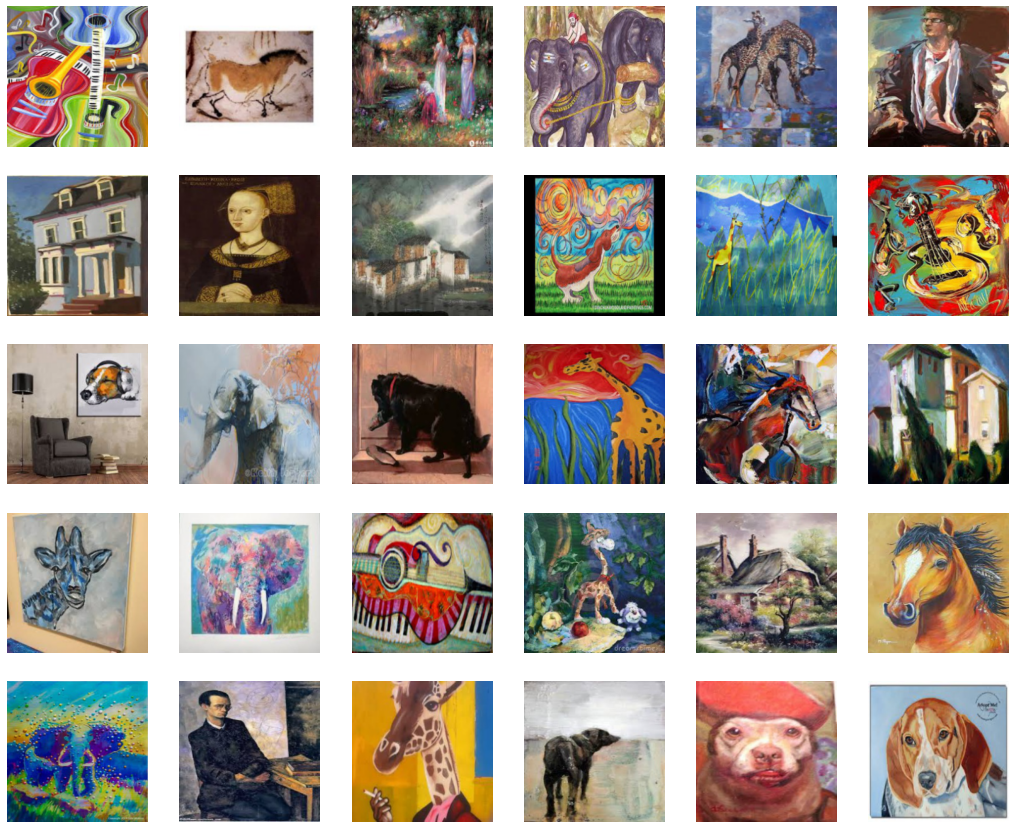

In [ ]:
test_dsets = dls.test_dl(get_image_files('test/0'))
test_dsets.show_batch(max_n=30, nrows=5)

#### 제출 형태 확인

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/programmers/data/test_answer_sample_.csv')
submission

Unnamed: 0  answer value
0             0             0
1             1             0
2             2             0
3             3             0
4             4             0
..          ...           ...
345         345             0
346         346             0
347         347             0
348         348             0
349         349             0

[350 rows x 2 columns]

In [ ]:
def get_pred_df(preds):
    label_dict = {'dog' : 0,
    'elephant' : 1,
    'giraffe' : 2,
    'guitar' : 3,
    'horse' : 4,
    'house' : 5,
    'person' : 6}

    temp_df = pd.DataFrame(preds)
    pred_df = temp_df.idxmax(axis=1).apply(lambda x: dls.train.vocab[x])
    pred_df = pd.concat([pred_df, pd.Series(test_dsets.items)],axis=1)
    pred_df.rename(columns={0:'label',1:'image'},inplace=True)
    pred_df = pred_df[['image','label']].sort_values(by='image').reset_index(drop=True)
    # pred_df.image = pred_df.image.astype(str).apply(lambda x: x.split('/')[-1].replace('.jpg','')).astype(int)
    pred_df.label = pred_df.label.apply(lambda x: label_dict[x])
    
    return pred_df

#### best single model

In [ ]:
preds, _ = best_models[1].to_fp16().tta(dl=test_dsets)
prediction = get_pred_df(preds)
submission['answer value'] = prediction.label
submission

Unnamed: 0  answer value
0             0             6
1             1             3
2             2             3
3             3             2
4             4             3
..          ...           ...
345         345             6
346         346             3
347         347             3
348         348             5
349         349             1

[350 rows x 2 columns]

In [ ]:
submission.to_csv('single_preds.csv', index=False)

#### ensemble

In [ ]:
ensemble_preds = []
for model in best_models:
    preds, _ = model.to_fp16().tta(dl=test_dsets)
    ensemble_preds.append(np.array(preds))

In [ ]:
predictions = np.mean(ensemble_preds, axis=0)

In [ ]:
result = get_pred_df(predictions)
submission['answer value'] = result.label
submission

In [ ]:
submission.to_csv('ensemble_preds.csv', index=False)

#### 1. bs32 best single model
- LB 81.42857142857143

#### 2. bs32 ensemble model
- LB 85.71428571428571

#### 3. 1+cutmix+mixup+labelsmoothing best single model 
- LB 82.85714285714286

#### 4. 1+cutmix+mixup+labelsmoothing ensemble model 
- LB 88.57142857142857